## Read images

## Split data

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
import pathlib
import sklearn.datasets
from sklearn.model_selection import train_test_split

import copy
from PIL import Image

import glob

import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)

images = []
labels = []
classes = set()

image_width = 30
image_height = 30

for filename in data_dir.glob('*/*.*'):
    class_name = str(filename).split("/")[1]
    classes.add(class_name)
    im=copy.deepcopy(Image.open(filename).resize((image_width,image_height)).convert('LA'))
    #print(np.array(im).shape)
    images.append(np.array(im)[...,:1].reshape((image_width*image_height*1,)))
    #print(images[0].shape)
    labels.append(class_name)
    im.close()

classes = sorted(list(classes))
labels = [i for x in labels for i in range(len(classes)) if x == classes[i]]




Total no of images = 9008


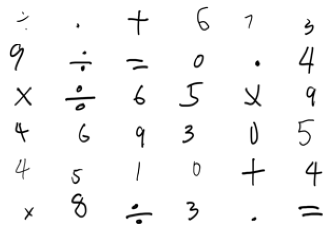

In [39]:
import random

for i,j in enumerate(random.sample(range(len(images)), 36)):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[j].reshape(30,30,), cmap='gray')
    #plt.title(classes[labels[j]])
    plt.axis("off")


(9008, 900)


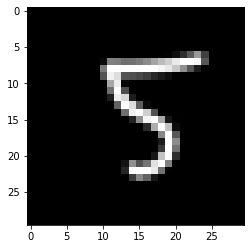

In [2]:
dataX = np.array(images).reshape((len(images), images[0].shape[0]))


#dataX[dataX <  128] = 0
#dataX[dataX >= 128] = 1
dataX = 1 - dataX / 255

plt.imshow(dataX[0].reshape(image_width, image_height), cmap="gray")

dataY = np.array(labels).reshape((len(labels),1))
print(dataX.shape)

In [3]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#print(x_train, x_val, x_test)

In [4]:
num_classes = 16
img_channels = 1

'''
model = Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu',input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128),
  layers.Dense(num_classes),
  #keras.layers.Dense(num_classes, activation='softmax')
])
'''


#Defining the Convolutional Neural Network
cnn_model = Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), input_shape = (img_width,img_height,img_channels), activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), input_shape = (img_width,img_height,img_channels), activation='relu'))
cnn_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(units = 512, activation = 'relu'))
cnn_model.add(layers.Dense(units = num_classes, activation = 'softmax'))
# After defining our model, we will check the model by its summary.

#CNN Model Summary
cnn_model.summary()

NameError: name 'Sequential' is not defined

In [ ]:

'''
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

In [ ]:
model.summary()

In [ ]:

print(x_train.shape, y_train.shape)

epochs = 10
'''
inputs = tf.keras.layers.Input(shape=(3,))
outputs = tf.keras.layers.Dense(2)(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model.metrics_names
x = np.random.random((2, 3))
y = np.random.randint(0, 2, (2, 2))
model.fit(x, y,epochs=epochs)
'''
history = cnn_model.fit(
  x_train.reshape(len(x_train), 30, 30, 1),
  y_train,
  epochs=epochs
)


In [ ]:
acc = history.history['accuracy']
print(history.history)
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
score = cnn_model.evaluate(x_test.reshape(len(x_test), 30, 30, 1), y_test, verbose = 0) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = cnn_model.evaluate(x_val.reshape(len(x_val), 30, 30, 1), y_val, verbose = 0) 
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

score = cnn_model.evaluate(x_train.reshape(len(x_train), 30, 30, 1), y_train, verbose = 0) 
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

y_pred = cnn_model.predict(x_test.reshape(len(x_test), 30, 30, 1))
'''
print(y_pred[0], tf.argmax(y_pred[0]), [y for x, y in val_ds][0])
print(val_ds)
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

        
plt.show()    
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


print(y_pred.shape)
'''
#y_pred = tf.nn.softmax(y_pred)

print(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)


#true_categories = tf.concat([y for x, y in val_ds], axis=0)
true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, class_names, normalize=False)

In [ ]:
test_image_path = "9.png"

img = keras.preprocessing.image.load_img(
 test_image_path, target_size=(img_height, img_width,1), color_mode="grayscale"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  #Create a batch

predictions = cnn_model.predict(img_array)
print(predictions)
score = predictions
#score = tf.nn.softmax(predictions[0])
'''

im=copy.deepcopy(Image.open(test_image_path).resize((image_width,image_height)).convert('LA'))
img_array = np.array(im)[...,:1].reshape((1,image_width,image_height,1))
im.close()

print(img_array.shape)
score = predictions = cnn_model.predict(img_array)
'''
print(
"This image most likely belongs to {} with a {:.2f} percent confidence."
.format(classes[np.argmax(score)], 100 * np.max(score))
)